<a href="https://www.kaggle.com/code/georgeliu/imdb-text-classification-with-transformers?scriptVersionId=124506467" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## 1. Set up Environment

In [1]:
!pip install evaluate

import os
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score

import torch
import datasets
from datasets import load_dataset, load_from_disk
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import evaluate
from evaluate import evaluator

seed = 168

print(f'Huggingface Datasets verion: {datasets.__version__}')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 4.4 MB/s eta 0:00:00
Huggingface Datasets verion: 2.1.0


## 2. Get and Prepare Data

In [2]:
imdb = load_dataset('imdb')
imdb

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [3]:
train_ds, test_ds = imdb['train'], imdb['test']
train_ds, test_ds

(Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }))

In [4]:
test_splits = test_ds.train_test_split(test_size=.5, seed=seed)
validation_ds, test_ds = test_splits['train'], test_splits['test']
validation_ds, test_ds

(Dataset({
     features: ['text', 'label'],
     num_rows: 12500
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 12500
 }))

In [5]:
inference_ds = imdb['unsupervised']
inference_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 50000
})

In [6]:
# Sample all datasets
random_sample_size = 1000
train_ds = train_ds.shuffle(seed=seed).select(range(random_sample_size))
validation_ds = validation_ds.shuffle(seed=seed).select(range(random_sample_size))
test_ds = test_ds.shuffle(seed=seed).select(range(random_sample_size))
inference_ds = inference_ds.shuffle(seed=seed).select(range(random_sample_size))

## 3. EDA

In [7]:
path = './'
name = 'train_ds.hf'
path_name = os.path.join(path, name)
train_ds.save_to_disk(path_name)

Flattening the indices:   0%|          | 0/1 [00:00<?, ?ba/s]

In [8]:
test_ds.save_to_disk('test_ds.hf')
validation_ds.save_to_disk('validation_ds.hf')
inference_ds.save_to_disk('inference_ds.hf')

Flattening the indices:   0%|          | 0/1 [00:00<?, ?ba/s]

Flattening the indices:   0%|          | 0/1 [00:00<?, ?ba/s]

Flattening the indices:   0%|          | 0/1 [00:00<?, ?ba/s]

In [9]:
train_ds.set_format(type='pandas')
#train_ds.format
df_train = train_ds[:]
df_train

,text,label
0,"I will stat of with the plot Alice, having sur...",0
1,OK... this movie so far has been slated by cri...,1
2,"No scenario, bad actors (poor Melissa Gilbert)...",0
3,I had hoped this movie was going to be mildly ...,0
4,I am decidedly not in the target audience for ...,1
...,...,...
995,This show was appreciated by critics and those...,1
996,"""The College Girl Murders"" is my first acquain...",1
997,I came to NEW PORT SOUTH expecting a surrogate...,0
998,The peculiar charisma of Martin Kosleck brings...,0


In [10]:
# Add new column to show label names
def label_int2str(label_value):
    return train_ds.features['label'].int2str(label_value)

df_train['label_name'] = df_train['label'].apply(label_int2str)
df_train.sample(20)

,text,label,label_name
157,"TV pilots, don't you love them? Quinn Martin t...",0,neg
468,"Typical 90's comedy, situational comedy simila...",1,pos
539,"""All the world's a stage and its people actors...",1,pos
387,As an employee of the Swedish Air Force I enjo...,1,pos
717,No need to detail what others have written in ...,0,neg
185,A struggling actor finds the best way to break...,1,pos
192,"This movie looked good - good cast, evergreen ...",0,neg
377,Everyone else who has commented negatively abo...,0,neg
63,I had read an article about Dan Jansen's Olymp...,1,pos
196,"Before Dogma 95: when Lars used movies as art,...",1,pos


<AxesSubplot:>

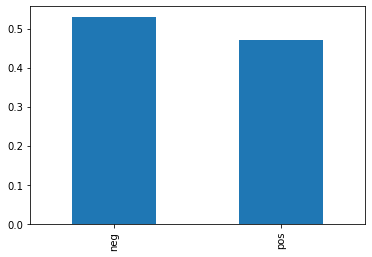

In [11]:
df_train.label_name.value_counts(normalize=True).plot(kind='bar')

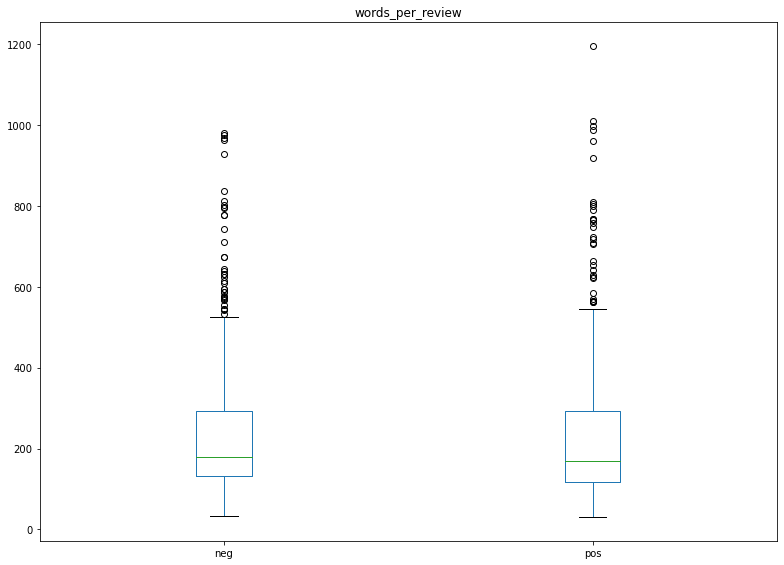

In [12]:
# Check text length
df_train['words_per_review'] = df_train.text.str.split().apply(len)
df_train.boxplot('words_per_review', by='label_name', grid=False, showfliers=True, figsize=(6.4*2, 4.8*2))
plt.suptitle('')
plt.xlabel('')
plt.show()

The majority of the reviews are shorter than DistilBERT's context size 512, with some outliers much longer.

In [13]:
train_ds.reset_format()
train_ds.format

{'type': None,
 'format_kwargs': {},
 'columns': ['text', 'label'],
 'output_all_columns': False}

## 4. Train Model

In [14]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'The device available is: {device}')
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
print(f'The tokenizer\'s max input length is: {tokenizer.model_max_length}')

The device available is: cuda


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

The tokenizer's max input length is: 512


In [15]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

train_ds_encoded = train_ds.map(tokenize, batched=True, batch_size=None)
validation_ds_encoded = validation_ds.map(tokenize, batched=True, batch_size=None)
test_ds_encoded = test_ds.map(tokenize, batched=True, batch_size=None)
inference_ds_encoded = inference_ds.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [16]:
num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

In [17]:
"""
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    #f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

"""
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


In [18]:
batch_size = 32
logging_steps = len(train_ds) // batch_size

training_args = TrainingArguments(
    output_dir='trainer_output',
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False, 
    log_level="error",
    report_to='none'
)

In [19]:
trainer = Trainer(
    model=model, 
    args=training_args, 
    compute_metrics=compute_metrics,
    train_dataset=train_ds_encoded,
    eval_dataset=validation_ds_encoded,
    tokenizer=tokenizer
)

trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy
1,0.643900,0.497458,0.851000
2,0.398500,0.368399,0.860000


TrainOutput(global_step=64, training_loss=0.5154145583510399, metrics={'train_runtime': 69.2922, 'train_samples_per_second': 28.863, 'train_steps_per_second': 0.924, 'total_flos': 264934797312000.0, 'train_loss': 0.5154145583510399, 'epoch': 2.0})

## 5. Test Model

In [20]:
# Test using evaluator
task_evaluator = evaluator("text-classification")

results = task_evaluator.compute(
    model_or_pipeline=model,
    data=test_ds,
    tokenizer=tokenizer,
    metric="accuracy",
    label_mapping={"LABEL_0": 0.0, "LABEL_1": 1.0},
    strategy="bootstrap",
    n_resamples=10,
    random_state=0
)

pprint(results)

{'accuracy': {'confidence_interval': (0.854, 0.879),
              'score': 0.867,
              'standard_error': 0.009605553948974875},
 'latency_in_seconds': 0.00774334068799999,
 'samples_per_second': 129.14322645647246,
 'total_time_in_seconds': 7.743340687999989}


In [21]:
# Test using trainer's predict method
#test_ds_tokenized = test_ds.map(tokenize)
preds, labels, metrics = trainer.predict(test_ds_encoded)
pprint(metrics)

{'test_accuracy': 0.867,
 'test_loss': 0.3625064492225647,
 'test_runtime': 8.5971,
 'test_samples_per_second': 116.319,
 'test_steps_per_second': 3.722}


## 6. Save Model

In [22]:
# save the model/tokenizer
model.save_pretrained("model")
tokenizer.save_pretrained("tokenizer")

# load the model/tokenizer
from transformers import AutoModelForTokenClassification
model = AutoModelForSequenceClassification.from_pretrained("model")
tokenizer = AutoTokenizer.from_pretrained("tokenizer")

## 7. Make Inference on New Data

In [23]:
trainer.predict(inference_ds_encoded.remove_columns('label'))

PredictionOutput(predictions=array([[-1.0524708 ,  0.736527  ],
       [ 0.0758449 , -0.23707385],
       [ 0.7907462 , -0.74480975],
       ...,
       [-0.44147572,  0.01934743],
       [-0.9061129 ,  0.50106657],
       [-0.8929781 ,  0.41040283]], dtype=float32), label_ids=None, metrics={'test_runtime': 8.6097, 'test_samples_per_second': 116.148, 'test_steps_per_second': 3.717})

In [24]:
text = ["I like the film it's really exciting!", "I hate the movie, it's so boring!!"]
encoding = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
outputs = model(**encoding)
predictions = outputs.logits.argmax(-1)

In [25]:
df_pred = pd.DataFrame(
    data=list(zip(text, np.array(predictions))),
    columns=['text', 'sentiment']
)
df_pred

,text,sentiment
0,I like the film it's really exciting!,1
1,"I hate the movie, it's so boring!!",0
